In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString, shape, Point
import openrouteservice
from tqdm import tqdm
import osmnx as ox
print(ox.__version__)  # pour vérifier
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

2.0.2


In [3]:
# ETAPE 1 – Uploader nos données
# 📁 SIP (centres d’impôts) – Datagouv 
df = pd.read_csv(r"C:\Users\Leo\Desktop\Carte\besac3.csv", sep=";", on_bad_lines='skip')
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]
centres_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
centres_proj = centres_gdf.to_crs(epsg=3857)

# 📁 Espaces France Services – Datagouv
df_fs = pd.read_csv(r"C:\Users\Leo\Desktop\Carte\fr-service-geocode2.csv", sep=";", on_bad_lines='skip')
geometry = [Point(xy) for xy in zip(df_fs["longitude"], df_fs["latitude"])]
fs_gdf = gpd.GeoDataFrame(df_fs, geometry=geometry, crs="EPSG:4326")
fs_proj = fs_gdf.to_crs(epsg=3857)

# 📁 Communes de passage frontaliers – INSEE
communes_df = pd.read_csv(r"C:\Users\Leo\Desktop\Carte\passages_geocode2.csv", sep=";", on_bad_lines='skip')
communes_geom = [Point(xy) for xy in zip(communes_df["longitude"], communes_df["latitude"])]
communes_gdf = gpd.GeoDataFrame(communes_df, geometry=communes_geom, crs="EPSG:4326")
communes_proj = communes_gdf.to_crs(epsg=3857)

# 📁 Données sur les enquêtés - Reugney/ Mouthe
enquetes_df = pd.read_csv(r"C:\Users\Leo\Desktop\Carte\enquetes.csv", sep=";", on_bad_lines='skip')
enquetes_geom = [Point(xy) for xy in zip(enquetes_df["longitude"], enquetes_df["latitude"])]
enquetes_gdf = gpd.GeoDataFrame(enquetes_df, geometry=enquetes_geom, crs="EPSG:4326")
enquetes_proj = enquetes_gdf.to_crs(epsg=3857)

In [5]:
# ETAPE 1.2 – Contours des départements

departements = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson")
doubs = departements[departements["nom"] == "Doubs"]

# ✅ Identifier les départements voisins
departements = departements.to_crs(epsg=2154)
doubs = doubs.to_crs(epsg=2154)
buffer_doubs = doubs.buffer(0.1)
voisins = departements[departements.geometry.intersects(buffer_doubs.iloc[0])]
voisins = voisins[voisins["nom"] != "Doubs"]

# ✅ Reprojection pour affichage (EPSG:3857)
doubs_proj = doubs.to_crs(epsg=3857)
voisins_proj = voisins.to_crs(epsg=3857)

# ✅ Fusion contours Doubs + voisins
all_deps_proj = pd.concat([doubs_proj, voisins_proj])

In [7]:
# ÉTAPE 1.3 – Frontière France–Suisse (https://overpass-turbo.eu/)

frontiere_gdf = gpd.read_file(r"C:/Users/Leo/Desktop/Carte/frontiere_fr_ch.geojson")
if frontiere_gdf.crs != "EPSG:3857":
    frontiere_gdf = frontiere_gdf.to_crs(epsg=3857)

frontiere_gdf = frontiere_gdf.boundary

In [9]:
# ÉTAPE 2 – Récupération des routes principales (https://overpass-turbo.eu/)

edges_proj = gpd.read_file(r"C:/Users/Leo/Desktop/Carte/export.geojson")
edges_proj = edges_proj.to_crs(epsg=3857)

In [11]:
# ETAPE 3 – Génération des isochrones pour les centres d'impôts uniquement (30 minutes de route)

# 🔑 Client ORS — insère ta clé ici
ors_client = openrouteservice.Client(key="5b3ce3597851110001cf62484ca8f1fe28a848ffa6321f29e45ca0d2")

isochrones = []

for idx, row in tqdm(centres_gdf.iterrows(), total=centres_gdf.shape[0]):
    coord = (row["longitude"], row["latitude"])

    try:
        result = ors_client.isochrones(
            locations=[coord],
            profile='driving-car',
            range=[30 * 60],  # 20 minutes
            units='m',
            attributes=['area'],
            interval=None
        )

        poly = shape(result['features'][0]['geometry'])
        isochrones.append({
            "ville": row["ville"],
            "geometry": poly
        })
    except Exception as e:
        print(f"Erreur pour {row['ville']} : {e}")

# 🗺️ Convertir en GeoDataFrame
isochrones_gdf = gpd.GeoDataFrame(isochrones, crs="EPSG:4326")
isochrones_proj = isochrones_gdf.to_crs(epsg=3857)

100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


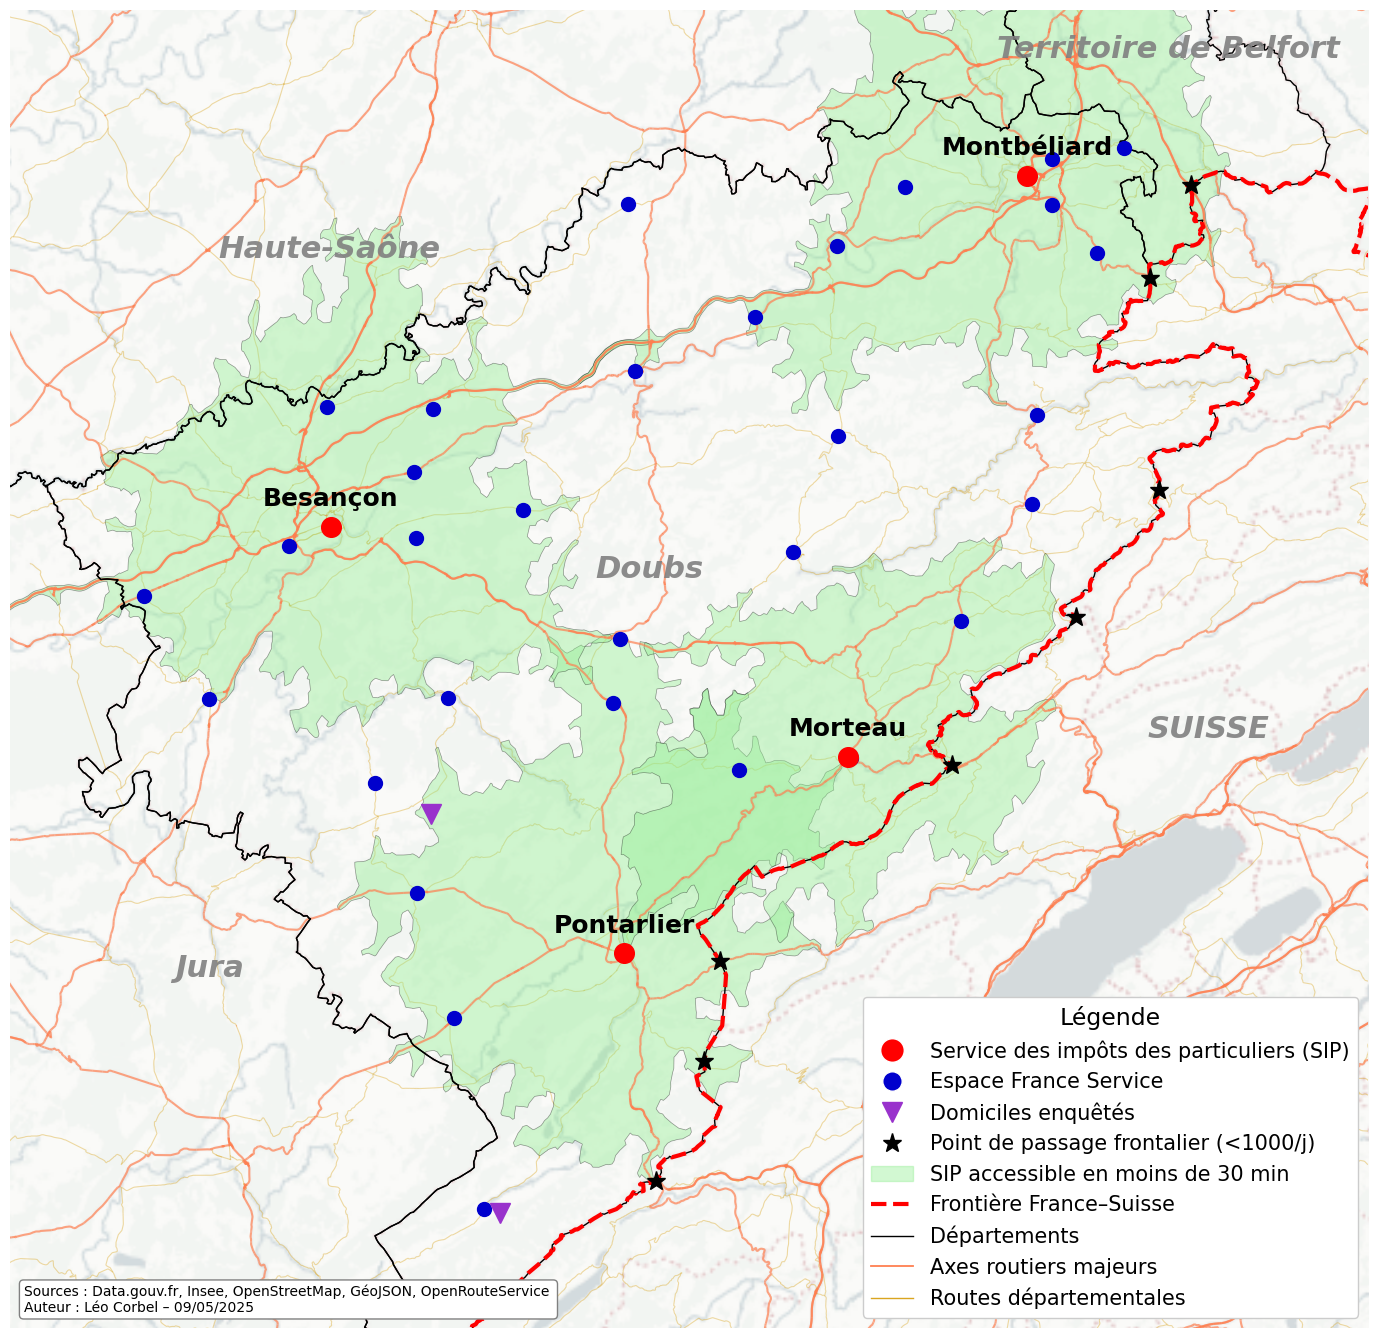

In [49]:
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib as mpl

# 🎨 Créer la figure
fig, ax = plt.subplots(figsize=(14, 14))

# 🗺️ Cadrage
xlim = (630000, 800000)
ylim = (5880000, 6045000)


# 🖼️ Fond de carte raster
img, ext = ctx.bounds2img(*xlim, *ylim, ll=False, source=ctx.providers.CartoDB.PositronNoLabels, zoom=9)
ax.imshow(img, extent=ext, interpolation='bilinear', zorder=0)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

# 🔲 Contours des départements
all_deps_proj.boundary.plot(ax=ax, edgecolor="black", linewidth=1, zorder=3)

# ÉTIQUETTES
# ✍️ ÉTIQUETTE - Suisse (même style que les départements)
ax.text(
    780000, 5955000, "SUISSE",  # Beaucoup plus au nord et à droite  # Déplacé plus au nord et à droite
    fontsize=22,
    color="grey",
    alpha=0.9,
    ha="center",
    va="center",
    fontweight="bold",
    fontstyle="italic",
    zorder=10
)

# ✍️ ÉTIQUETTES - Doubs + Départements voisins (centrés uniquement si visibles)
deps_to_label = pd.concat([doubs_proj, voisins_proj])
positions = {
    "Doubs": (710000, 5975000),  # Doubs plus au nord
    "Jura": (655000, 5925000),   # Jura plus à gauche
    "Haute-Saône": (670000, 6015000),  # Haute-Saône beaucoup plus au nord et à gauche
    "Territoire de Belfort": (775000, 6040000),   # Territoire de Belfort déplacé un peu plus au sud,
    "Côte-d'Or": (675000, 5980000)  # Côte-d'Or ajustée pour la rendre visible
}

for idx, row in deps_to_label.iterrows():
    nom = row["nom"]

    if nom in positions:
        x, y = positions[nom]
    else:
        x, y = row.geometry.centroid.x, row.geometry.centroid.y

    # Texte principal (gras, non italique)
    ax.text(
        x, y, nom,
        fontsize=22,
        color="grey",
        ha="center",
        va="center",
        fontweight="bold",
        fontstyle="italic",
        alpha=0.9,
        zorder=10
    )

# ✍️ ÉTIQUETTES - 4 grandes villes depuis le fichier CSV (centré au-dessus)

villes = ["Besançon", "Montbéliard", "Pontarlier", "Morteau"]
for nom in villes:
    match = centres_proj[centres_proj["ville"].str.lower() == nom.lower()]
    if not match.empty:
        pt = match.geometry.iloc[0]
        ax.text(
            pt.x, pt.y + 2000,  # petit décalage VERS LE HAUT pour être au-dessus
            nom,
            fontsize=18,
            color="black",
            fontweight="bold",
            ha="center",  # centrage horizontal
            va="bottom",  # l'étiquette commence juste au-dessus du point
            zorder=9
        )

# 🟢 Isochrones
if not isochrones_proj.empty:
    isochrones_proj.plot(ax=ax, facecolor="lightgreen", edgecolor="black", alpha=0.4, linewidth=0.5, zorder=2)


# 🚗 ROUTES - 2 catégories : autoroutes / nationales+rapides / départementales
if 'edges_proj' in globals() and "highway" in edges_proj.columns:

    departementales = edges_proj[edges_proj["highway"] == "secondary"]
    autres_routes = edges_proj[~edges_proj["highway"].isin(["secondary"])]

    departementales.plot(ax=ax, color="goldenrod", linewidth=0.8, alpha=0.4, zorder=1)
    autres_routes.plot(ax=ax, color="coral", linewidth=1.5, alpha=0.7, zorder=2)

centres_proj.plot(ax=ax, color="red", markersize=200, zorder=12) # Centres d’impôts
fs_proj.plot(ax=ax, color="mediumblue", markersize=100, zorder=7) # Espaces France Services

# 🚗 Communes de passage
for idx, row in communes_proj.iterrows():
    ax.plot(row.geometry.x, row.geometry.y, marker='*', color='black', markersize=14, zorder=7)

# 🏡 Enquêtés
for idx, row in enquetes_proj.iterrows():
    ax.plot(row.geometry.x, row.geometry.y, marker='v', color='darkorchid', markersize=14, zorder=8)

if not frontiere_gdf.empty:
    frontiere_gdf.plot(ax=ax, color="red", linestyle="--", linewidth=3, zorder=6) # ⚫ Frontière France–Suisse


# Légende
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=17, label="Service des impôts des particuliers (SIP)"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='mediumblue', markersize=14, label="Espace France Service"),
    Line2D([0], [0], marker='v', linestyle='None', color='darkorchid', markersize=14, label="Domiciles enquêtés"),
    Line2D([0], [0], marker='*', linestyle='None', color='black', markersize=14, label="Point de passage frontalier (<1000/j)"),
    mpatches.Patch(color="lightgreen", alpha=0.4, label="SIP accessible en moins de 30 min"),
    Line2D([0], [0], color='red', linestyle='--', linewidth=3, label="Frontière France–Suisse"),
    Line2D([0], [0], color='black', linewidth=1, label="Départements"),
    Line2D([0], [0], color='coral', linewidth=1.3, label="Axes routiers majeurs"),
    Line2D([0], [0], color='goldenrod', linewidth=1, label="Routes départementales"),
]

# 📘 Affichage de la légende avec fond blanc opaque
legend = ax.legend(
    handles=legend_elements,
    title="Légende",
    loc="lower right",
    fontsize=15,
    title_fontsize=17,
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1.0)  # opacité totale
ax.axis("off")

ax.text(
    0.01, 0.01,
    "Sources : Data.gouv.fr, Insee, OpenStreetMap, GéoJSON, OpenRouteService \nAuteur : Léo Corbel – 09/05/2025",
    fontsize=10,
    ha="left",
    va="bottom",
    transform=ax.transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=1.0),  # alpha=1.0 pour un fond blanc opaque
    zorder=100
)


plt.tight_layout()

# Sauvegarde
plt.savefig("carte_services_doubs_finale.png", dpi=300)
plt.show()